In [136]:
# %load_ext autoreload
# %autoreload 2

import torchvision
import numpy as np
from torch.utils import data
from matplotlib import pyplot as plt
import torchvision.transforms.v2 as transforms
import torch
from encoder import CenternetEncoder
from visualizer import get_image_with_bboxes
from model import input_height, input_width, ModelBuilder
from dataset import Dataset


print("GPU is available: ", torch.cuda.is_available())

plt.rcParams['figure.figsize'] = (12.0, 8.0)


GPU is available:  False


In [137]:
dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set="val", download=False)
dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)
print(len(dataset_val))

2510


In [138]:
encoder = CenternetEncoder(input_height, input_width)
transform = transforms.Compose([transforms.Resize(size=(input_width, input_height)), transforms.ToTensor()])
torch_dataset = Dataset(dataset=dataset_val, transformation=transform, encoder=encoder)

# these 10 pictures from the VOC dataset were randomly selected for model training
subset_indices = torch.tensor([955, 1025, 219, 66, 1344, 222, 865, 2317, 86, 1409])

down_ratio = 4


In [139]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelBuilder(alpha=0.25).to(device)
# summary(model, input_size = (3, 256, 256), batch_size = -1)

loss_dict = {}


In [140]:
model.load_state_dict(torch.load("./trained_model", weights_only=False))

<All keys matched successfully>

{'boxes': BoundingBoxes([[ 33, 109, 260, 334],
               [  1, 165, 259, 334],
               [323, 161, 353, 220],
               [323, 164, 500, 334],
               [309, 170, 461, 334]], format=BoundingBoxFormat.XYXY, canvas_size=(334, 500)), 'labels': tensor([15, 18,  9,  9, 15])}


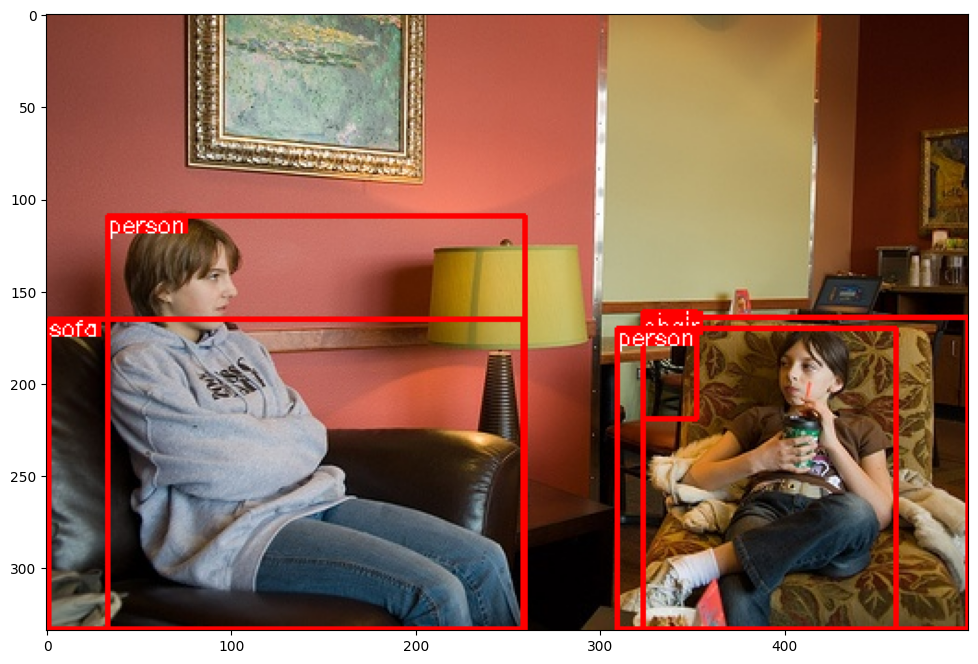

In [141]:
# just to explore heatmap for some specific image used in model training

image_index = 5  # 0 (car) is also a good choice

img, lbl = dataset_val[subset_indices[image_index]]
print(lbl)

# 
image_with_boxes = get_image_with_bboxes(img, lbl['boxes'], lbl['labels'])
plt.imshow(image_with_boxes)

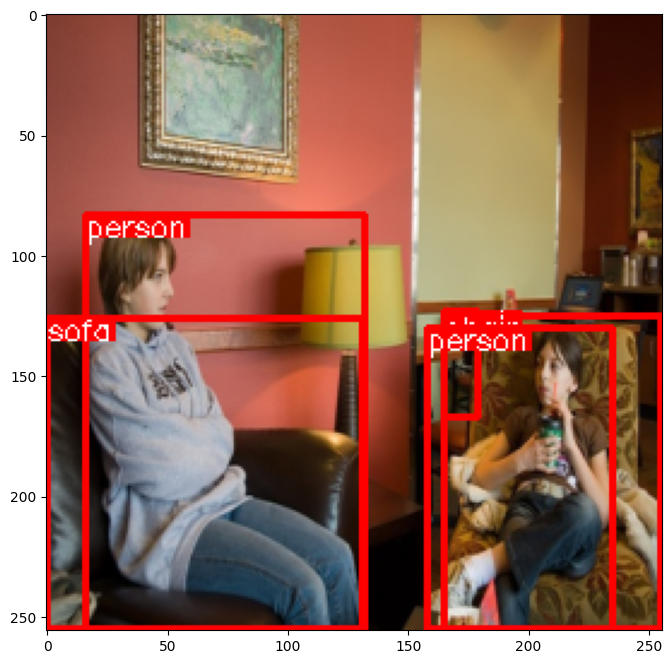

In [142]:
transform = transforms.Compose([transforms.Resize(size=(input_width, input_height))])
img_transformed, bboxes, labels = transform(img, lbl['boxes'], lbl['labels'])

image_with_boxes = get_image_with_bboxes(img_transformed,  bboxes, labels)
plt.imshow(image_with_boxes)

down_ratio = 4
rect center: [168  76]
coors [ 16.  83. 133. 256.]

rect center: [192 196]
coors [158. 130. 236. 256.]



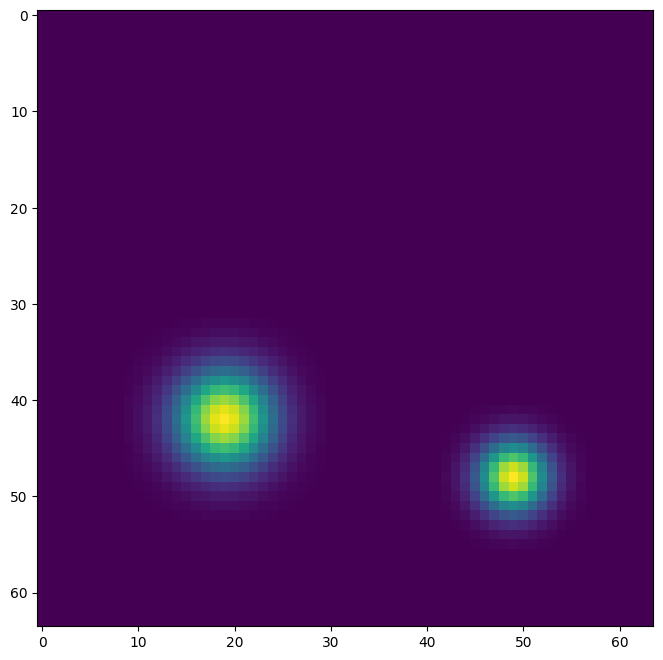

In [143]:
encoder = CenternetEncoder(input_height, input_width)
lbl_encoded = encoder(bboxes, labels)

hm_chosen = lbl_encoded[..., lbl['labels'][0]-1]

ind_max = np.argwhere(hm_chosen == np.amax(hm_chosen))
for ind in ind_max:
    print("rect center:", ind * 4)
    print("coors", lbl_encoded[..., 20:][ind[0], ind[1]])
    print()

plt.imshow(lbl_encoded[..., lbl['labels'][0]-1])

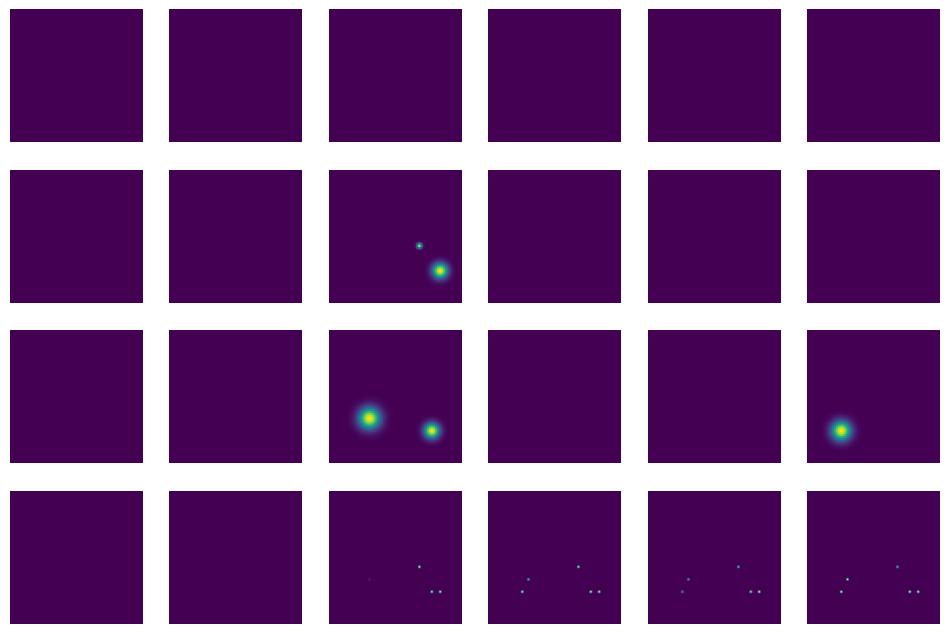

In [144]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
for y in range(6):
    for i in range(4):
        plt_idx = i + y * 4 + 1
        plt.subplot(4, 6, plt_idx)
        plt.imshow(lbl_encoded[...,plt_idx-1])
        plt.axis('off')
plt.show()

There are 12 persons in dataset


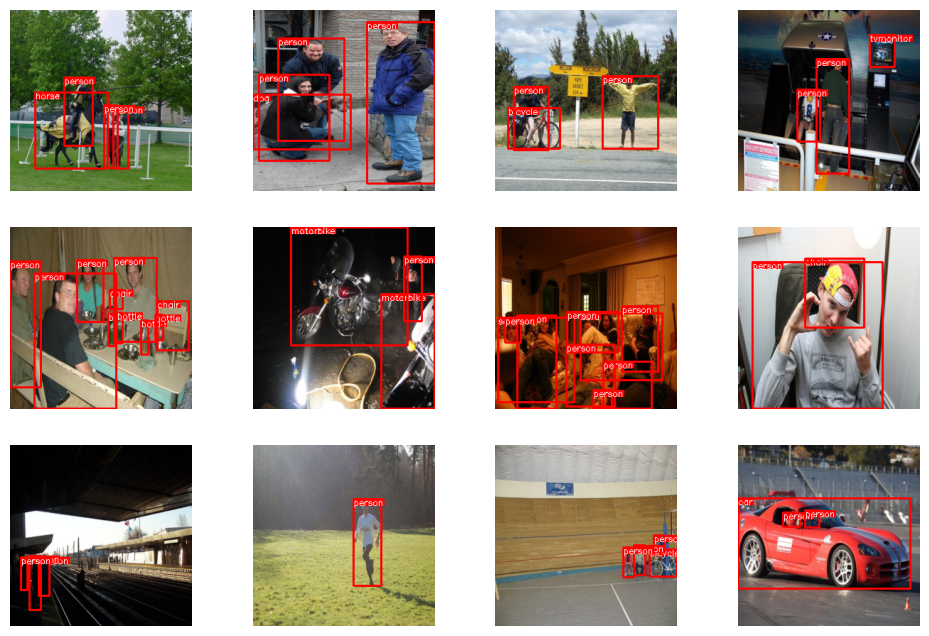

In [145]:
# Filter the entire VOC dataset to get 12 images containing persons. Label = 15
number_of_persons = 12
person_label = 15

person_images = []
indexes = []

for index, (img, lbl) in enumerate(dataset_val):
    if person_label in lbl['labels']:  # 15 refer to a person
        indexes.append(index)
        person_images.append({'index': index, 'image': img, 'lbl': lbl})
    if len(indexes) == number_of_persons:
        break
test_data = torch.utils.data.Subset(torch_dataset, indexes)

print(f'There are {len(person_images)} persons in dataset')

# Visualize first 10 persons from the dataset.
# They form my test data.
for y in range(4):
    for i in range(3):
        plt_idx = i + y * 3 + 1
        plt.subplot(3, 4, plt_idx)

        transform = transforms.Compose([transforms.Resize(size=(input_width, input_height))])
        img_transformed, bboxes, labels = transform(
            person_images[plt_idx-1]['image'], 
            person_images[plt_idx-1]['lbl']['boxes'], 
            person_images[plt_idx-1]['lbl']['labels']
        )

        image_with_boxes = get_image_with_bboxes(img_transformed, bboxes, labels)
        plt.imshow(image_with_boxes)
        
        plt.axis('off')
plt.show()

In [151]:
# Here I am trying to get the loss for test data received with trained model

img, lbl = test_data[0]
model.eval()
img_reshaped = torch.reshape(img, [1, 3, 256, 256])

# todo (AA): I don't completely understand what the this prediction contain
result = model.forward(img_reshaped.to(device))
print(result.shape)

# todo (AA): Does it make sense to present a heatmap for the derived prediction?
numpy_result = result.detach().numpy()
print(numpy_result.shape)

for i in range(20):
    print(np.max(numpy_result[0, i, :, :]))
    
# todo (AA): How to get the loss?

torch.Size([1, 24, 64, 64])
(1, 24, 64, 64)
0.016291715
0.01634728
0.016055206
0.96730053
0.0163589
0.016212398
0.14647487
1.0
0.13859946
0.029834293
0.016109759
0.99752444
0.017051766
0.017091164
0.6817233
0.9841568
0.016270109
0.95018744
0.016371673
0.016190456


In [56]:
# Set the model to evaluation mode:
# model.eval()
# model.train(False)
# 
# test_dataset = Dataset(dataset=test_data, transformation=transform, encoder=encoder)
# 
# batch_generator = torch.utils.data.DataLoader(test_dataset)
# 
# for _, data in enumerate(batch_generator):
#     print('111111')
#     input, gt_data = data
#     input = input.to(device).contiguous()
#     
#     gt_data = gt_data.to(device)
#     gt_data.requires_grad = False
#     
#     loss_dict = model(input, gt=gt_data)
#     loss_dict['loss'].backward()
#     
#     print(loss_dict['loss'])
#     
# print('!!!!!')


# Predict on test data:
# batch_generator = torch.utils.data.DataLoader(
#     torch_dataset,
#     batch_size=1,
#     num_workers=1,
#     shuffle=False
# )

# input, gt_data = next(iter(batch_generator))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for batch in batch_generator:
#     print(batch)
#     break

# Disable gradient calculations:
# with torch.no_grad():
#     for _, (input2, gt_data) in enumerate(batch_generator):
#         input2 = input2.to(device).contiguous()
#         
#         gt_data = gt_data.to(device)
#         gt_data.requires_grad = False
#         
#         loss_dict = model(input2, gt=gt_data)
#     
# print(loss_dict)

IndexError: too many indices for tensor of dimension 3